## Imports

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from random import random, seed
from IPython.display import clear_output
import dataframe_image as dfi
from tqdm.notebook import tqdm, trange
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn import datasets

ModuleNotFoundError: No module named 'seaborn'

## Functions and classes

In [2]:
def create_X(x, y, n ):
        if len(x.shape) > 1:
                x = np.ravel(x)
                y = np.ravel(y)

        N = len(x)
        l = int((n+1)*(n+2)/2)                                                                        
        X = np.ones((N,l))

        for i in range(1,n+1):
                q = int((i)*(i+1)/2)
                for k in range(i+1):
                        X[:,q+k] = (x**(i-k))*(y**k)
#                         print("X^{}*Y^{}".format(i-k,k))

        return X

def MSE(y,ytilde):

    return sum((y-ytilde)**2) / len(y)

def R2(y,ytilde):
    first = sum((y-ytilde)**2)
    second = sum((y-np.mean(y))**2)
    
    return 1 - first / second
def Bias(y,ytilde):
    return sum((y_test - np.mean(ytilde))**2) / len(y)

def Variance(y,ytilde):
    return np.var(ytilde)

def KFoldSplit(X,n_folds):

    n_folds = n_folds
    lenoffolds = (len(X) / n_folds)
    folds = []
    for i in range(n_folds):
        if i == range(n_folds)[-1]:
            first_ix = int(lenoffolds)*i
            second_ix = int(lenoffolds)*(i+1) 
            if second_ix != len(X):
                second_ix += 1
            else:
                pass
        else:
            first_ix = int(lenoffolds)*i
            second_ix = int(lenoffolds)*(i+1) 
        test_ix = np.arange(first_ix,second_ix)
        train_ix = np.delete(np.arange(0,len(X)),np.arange(first_ix,second_ix))
        folds.append((train_ix,test_ix))
        
    return folds

def to_categorical_numpy(interger_vector):
    n_inputs = len(interger_vector)
    n_categories = np.max(interger_vector) + 1 
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs),interger_vector] = 1 
    
    return onehot_vector

In [3]:

class Layer:
    
    def __init__(self,n_input, n_neurons, activation=None, weights=None, bias=None, lrelu_alpha=0.01):
        
        self.n_neurons = n_neurons
        self.n_input = n_input
        
        self.weights = weights if weights is not None else np.random.randn(self.n_input, self.n_neurons)
        self.activation = activation
        self.bias = bias if bias is not None else np.random.rand(self.n_neurons)
        
        self.lrelu_alpha = lrelu_alpha
        
    def modify_layer(self,n_input=None,n_neurons=None,activation=None,weights=None, bias=None):
       
        self.n_neurons = n_neurons if n_neurons is not None else self.n_neurons
        self.n_input = n_input if n_input is not None else self.n_input
        self.activation = activation if activation is not None else self.n_input
        
        self.weights = weights if weights is not None else np.random.randn(self.n_input, self.n_neurons)
        self.activation = activation
        self.bias = bias if bias is not None else np.random.rand(self.n_neurons)
        
    def activate(self, x):
        
        z_h = np.matmul(x, self.weights) + self.bias
        self.z = np.matmul(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(z_h)
        return self.last_activation
    
    def _apply_activation(self,z_h):
        self.z_h = z_h
        if self.activation is None:
            return z_h
        
        if self.activation == "tanh":
            return np.tanh(z_h)
        
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z_h))
        
        if self.activation == "softmax":
            return np.exp(z_h) / np.sum(np.exp(z_h),axis=1, keepdims=True)
        
        if self.activation == "relu":
            
            return np.maximum(0,z_h)
            
        if self.activation == "leaky_relu":
            fx = z_h.copy()
            fx = np.where(fx<0,self.lrelu_alpha*fx,fx)
            
            return fx
        
        else:
            return self.activation(z_h)
    
    def apply_activation_derivative(self, f):
        import autograd.numpy as np
        from autograd import elementwise_grad as egrad
        
        if self.activation is None:
            return f
        
        if self.activation == "tanh":
            return 1 - f**2 
        
        if self.activation == "sigmoid":
            return f  * (1 - f)
        
        if self.activation == "softmax":
            return f  * (1 - f)
        
        if self.activation == "relu":
            fx = f.copy()
            fx = np.where(fx<=0, 0, 1)

            return fx 
        
        if self.activation == "leaky_relu":
            fx = f.copy()
            fx = np.where(self.z_h<0,self.lrelu_alpha,1)
            return fx
        else:
            return egrad(self.activation)(f) 

class NeuralNetwork:
    
    def __init__(self):
        self._layers = []
        
    def add_layer(self, layer):

        self._layers.append(layer)
        
    def feed_forward(self, X):
        
        for layer in self._layers:
            X = layer.activate(X)
        return X 
    
    def predict(self, X):
        
        output = self.feed_forward(X)

        if output.shape[1]==1:
            return output
        
        if output.ndim == 1: 
            return np.argmax(output)
        
        return np.argmax(output, axis=1)
    
    def backpropagation(self, X, y, eta=0.1, alpha=0):
        
        output = self.feed_forward(X)

        for i in reversed(range(len(self._layers))):
            
            layer = self._layers[i]
            
            if layer == self._layers[-1]:
#                 output = output.reshape(1,-1)
                layer.error = output - y
                layer.delta = layer.error
                
#                 layer.weight_gradient = np.matmul(layer.last_activation.T,layer.delta)
#                 layer.bias_gradient = np.sum(layer.delta, axis=0)
                
            
            else:
                next_layer = self._layers[i+1] 
                
                layer.delta = np.matmul(next_layer.delta,next_layer.weights.T) \
                * layer.apply_activation_derivative(layer.last_activation)
                
#                 layer.weight_gradient = np.matmul(layer.)

        for i in range(len(self._layers)):
            layer = self._layers[i]
            
#             a_l_minus_1 = np.atleast_2d(X if i == 0 else self._layers[i-1].last_activation)
            a_l_minus_1 = (X if i == 0 else self._layers[i-1].last_activation)
            if alpha != 0: 
                layer.weight_gradient += alpha * layer.weights
                
            layer.weight_gradient = np.matmul(a_l_minus_1.T,layer.delta)
            layer.bias_gradient = np.sum(layer.delta)
            
            layer.weights -= layer.weight_gradient * eta
            layer.bias -= layer.bias_gradient * eta
            
    def train(self, X, y, eta=0.1, max_epochs=10, batch_size=100,alpha=0,):
        self.iterations = X.shape[0] // batch_size
        
        data_indicies = np.arange(X.shape[0])
        
        for i in range(max_epochs):
                for j in range(self.iterations):
                    chosen_datapoints = np.random.choice( data_indicies, size = batch_size, replace=False )
                    
                    X_ = X[chosen_datapoints]
                    y_ = y[chosen_datapoints]
                    
                    self.backpropagation(X_,y_, eta)            
    

## Part d): Classification analysis using neural networks

In [4]:
digits = datasets.load_digits()
inputs = digits.images
labels = digits.target

X = inputs.reshape(len(inputs),-1)
X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=0.2)
y_train_onehot, y_test_onehot = to_categorical_numpy(y_train),to_categorical_numpy(y_test)
print("X shape",X.shape)
print("X_train shape: ",X_train.shape);
print("X test shape",X_test.shape)

X shape (1797, 64)
X_train shape:  (1437, 64)
X test shape (360, 64)


In [5]:
inputs.shape

(1797, 8, 8)

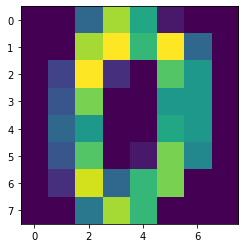

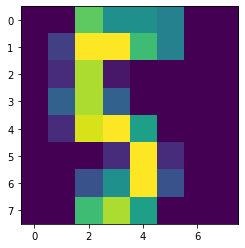

In [6]:
plt.imshow(inputs[0])
plt.savefig("Tex/figures/MNIST figure 1.png")
plt.show()
plt.imshow(inputs[25])
plt.savefig("Tex/figures/MNIST figure 2.png")
plt.show()

In [7]:
eta_vals = np.logspace(-5,-1,20)
epochs = 100
lmb = 0

In [8]:
np.log10(-5)

<ipython-input-8-7edcf14680cd>:1: RuntimeWarning: invalid value encountered in log10
  np.log10(-5)


nan

In [9]:
warnings.filterwarnings('ignore')

scores = []

for eta in tqdm(eta_vals):
    
    nn = NeuralNetwork()
    # First layer
    nn.add_layer(Layer(X.shape[1],100,"sigmoid"))
    # Output layer
    nn.add_layer(Layer(100,y_test_onehot.shape[1],"softmax"))
    nn.train(X_train,y_train_onehot,eta=eta,max_epochs=epochs,alpha=lmb)
    
    skl_nn = MLPClassifier(hidden_layer_sizes=100,
                              activation="logistic",
                              alpha=lmb,
                              learning_rate_init=eta,
                              batch_size=50,
                              max_iter=epochs)
    skl_nn.fit(X_train,y_train_onehot)

    skl_score = skl_nn.score(X_test, y_test_onehot)
    nn_score = accuracy_score(y_test,nn.predict(X_test))
    
    scores.append((nn_score,skl_score))
scores_df = pd.DataFrame((scores),index=eta_vals,columns=["FFNN","Sklearn NN"])

In [10]:
dfi.export(scores_df.rename_axis("Learning rate"),"Tex/Figures/Partd-1.png")
scores_df.rename_axis("Learning rate")

,FFNN,Sklearn NN
Learning rate,,
0.000010,0.136111,0.000000
0.000016,0.319444,0.000000
0.000026,0.422222,0.000000
0.000043,0.558333,0.347222
0.000070,0.558333,0.716667
0.000113,0.702778,0.891667
0.000183,0.780556,0.930556
0.000298,0.827778,0.941667
0.000483,0.847222,0.961111


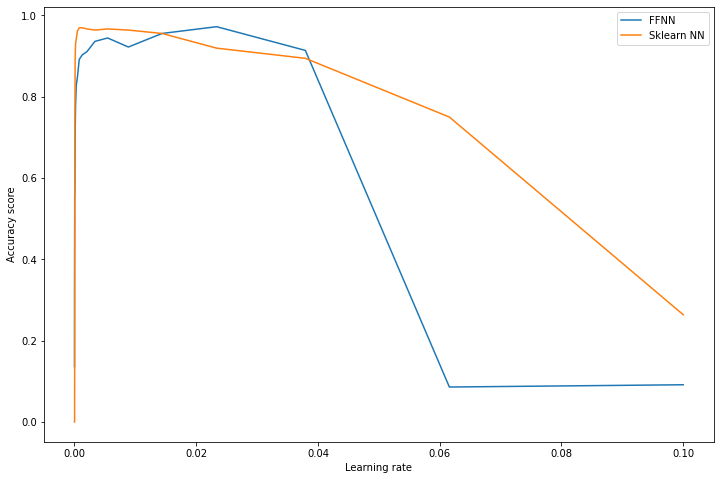

In [11]:
(scores_df).plot(figsize=(12,8))
plt.xlabel("Learning rate")
plt.ylabel("Accuracy score")
plt.savefig("Tex/Figures/Partd-2.png")

In [12]:
eta_vals = np.logspace(-3,-1,10)
eta_vals

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

In [13]:
eta_vals = np.logspace(-3,-1,10)
epochs = 100
lmb_vals = np.logspace(-5,-1,10)

scores = []

for eta in tqdm(eta_vals):
    lmb_scores = []
    for lmb in lmb_vals:
        nn = NeuralNetwork()
        # First layer
        nn.add_layer(Layer(X.shape[1],100,"sigmoid"))
        # Output layer
        nn.add_layer(Layer(100,y_test_onehot.shape[1],"softmax"))
        nn.train(X_train,y_train_onehot,eta=eta,max_epochs=epochs,alpha=lmb)

        skl_nn = MLPClassifier(hidden_layer_sizes=100,
                                  activation="logistic",
                                  alpha=lmb,
                                  learning_rate_init=eta,
                                  batch_size=50,
                                  max_iter=epochs)
        skl_nn.fit(X_train,y_train_onehot)

        skl_score = skl_nn.score(X_test, y_test_onehot)
        nn_score = accuracy_score(y_test,nn.predict(X_test))

        lmb_scores.append((nn_score,skl_score))
    scores.append(lmb_scores)
scores_df = pd.DataFrame((scores),index=eta_vals)

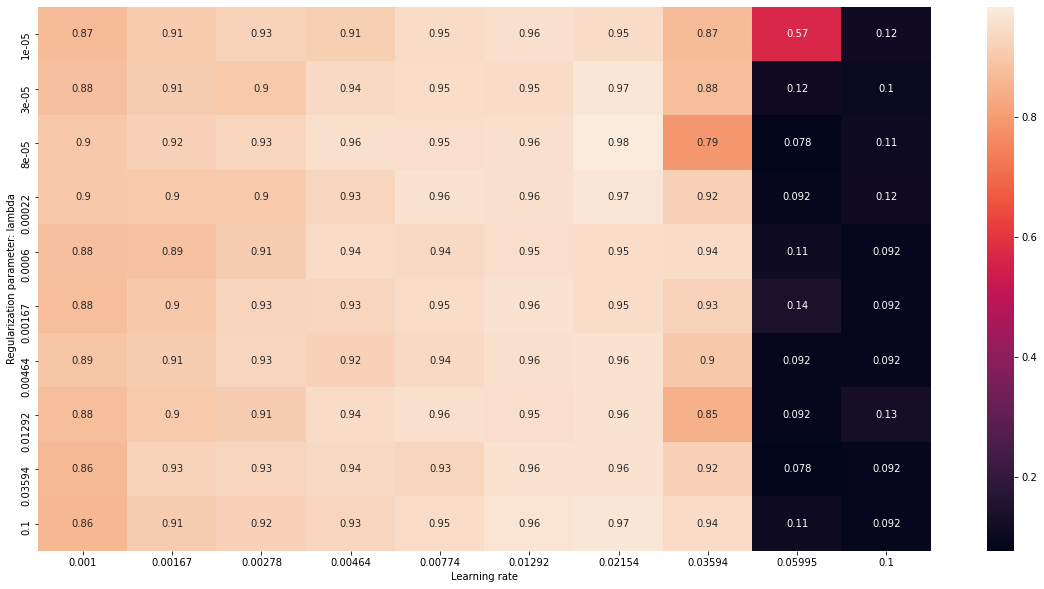

In [14]:
scores_df = pd.concat([pd.DataFrame(i,index=lmb_vals,columns=["FFNN","Skl MLP"]) for i in scores],axis=1,keys=eta_vals).rename_axis("Lambdas",axis=0).rename_axis(["Learning rate","Model"],axis=1)

plt.figure(figsize=(20,10))
df = scores_df.loc[:,pd.IndexSlice[:,"FFNN"]].droplevel(1,axis=1)
sns.heatmap(df,
            annot=True,
            xticklabels=df.columns.values.round(5),
            yticklabels=df.index.values.round(5))
plt.xlabel("Learning rate")
plt.ylabel("Regularization parameter: lambda")
plt.savefig("Tex/Figures/Partd-3.png")

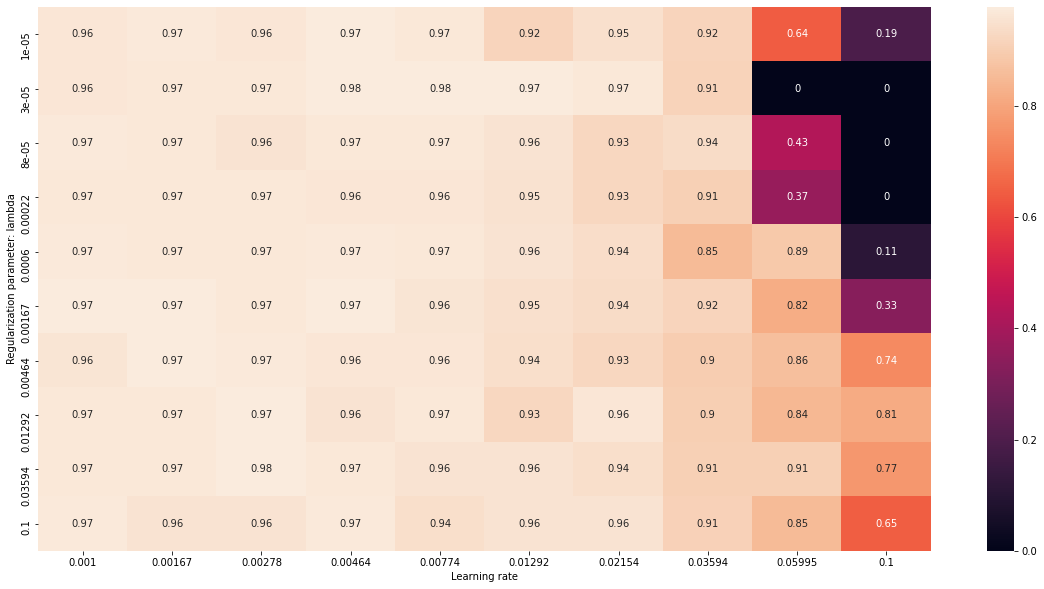

In [15]:
plt.figure(figsize=(20,10))
df = scores_df.loc[:,pd.IndexSlice[:,"Skl MLP"]].droplevel(1,axis=1)
sns.heatmap(df,
            annot=True,
            xticklabels=df.columns.values.round(5),
            yticklabels=df.index.values.round(5))
plt.xlabel("Learning rate")
plt.ylabel("Regularization parameter: lambda")
plt.savefig("Tex/Figures/Partd-4.png")

In [16]:
scores_df.loc[:,pd.IndexSlice[:,"FFNN"]].max(1).max(0)

0.9833333333333333

In [17]:
scores_df.loc[:,pd.IndexSlice[:,"Skl MLP"]].max(1).max(0)

0.9777777777777777

In [18]:
scores_df.loc[:,pd.IndexSlice[:,"FFNN"]]

Learning rate,0.001000,0.001668,0.002783,0.004642,0.007743,0.012915,0.021544,0.035938,0.059948,0.100000
Model,FFNN,FFNN,FFNN,FFNN,FFNN,FFNN,FFNN,FFNN,FFNN,FFNN
Lambdas,,,,,,,,,,
0.000010,0.866667,0.905556,0.925000,0.913889,0.947222,0.958333,0.947222,0.866667,0.566667,0.116667
0.000028,0.880556,0.911111,0.902778,0.938889,0.950000,0.947222,0.969444,0.875000,0.116667,0.100000
0.000077,0.900000,0.922222,0.930556,0.955556,0.952778,0.955556,0.983333,0.788889,0.077778,0.108333
0.000215,0.900000,0.902778,0.902778,0.933333,0.961111,0.955556,0.969444,0.919444,0.091667,0.116667
0.000599,0.880556,0.886111,0.911111,0.944444,0.938889,0.952778,0.950000,0.944444,0.111111,0.091667
0.001668,0.875000,0.900000,0.927778,0.930556,0.950000,0.961111,0.950000,0.925000,0.141667,0.091667
0.004642,0.891667,0.911111,0.933333,0.922222,0.938889,0.955556,0.961111,0.900000,0.091667,0.091667
0.012915,0.875000,0.902778,0.911111,0.944444,0.955556,0.952778,0.961111,0.847222,0.091667,0.127778


Experiment 2: Two hidden layers with 100 nodes 

In [19]:
eta_vals = np.logspace(-3,-1,10)
epochs = 100
lmb_vals = np.logspace(-5,-1,10)

scores = []
import warnings
warnings.filterwarnings('ignore') 
for eta in tqdm(eta_vals):
    lmb_scores = []
    for lmb in tqdm(lmb_vals,leave=bool(lmb == 2)):
        nn = NeuralNetwork()
        # First layer
        nn.add_layer(Layer(X.shape[1],100,"sigmoid"))
        # Mid layer
        nn.add_layer(Layer(100,100,"sigmoid"))
        # Output layer
        nn.add_layer(Layer(100,y_test_onehot.shape[1],"softmax"))
        nn.train(X_train,y_train_onehot,eta=eta,max_epochs=epochs,alpha=lmb)

        
        nn_score = accuracy_score(y_test,nn.predict(X_test))

        lmb_scores.append((nn_score))
    scores.append(lmb_scores)
scores_df = pd.DataFrame((scores),index=eta_vals)

In [20]:
scores_df

,0,1,2,3,4,5,6,7,8,9
0.001000,0.877778,0.908333,0.883333,0.886111,0.886111,0.891667,0.897222,0.877778,0.872222,0.875000
0.001668,0.916667,0.925000,0.894444,0.902778,0.916667,0.891667,0.913889,0.900000,0.897222,0.900000
0.002783,0.927778,0.916667,0.913889,0.908333,0.886111,0.905556,0.919444,0.911111,0.913889,0.916667
0.004642,0.925000,0.936111,0.911111,0.925000,0.938889,0.925000,0.952778,0.936111,0.933333,0.927778
0.007743,0.944444,0.952778,0.930556,0.938889,0.936111,0.936111,0.941667,0.944444,0.966667,0.933333
0.012915,0.938889,0.944444,0.947222,0.955556,0.952778,0.950000,0.941667,0.944444,0.955556,0.941667
0.021544,0.963889,0.966667,0.969444,0.955556,0.977778,0.950000,0.952778,0.958333,0.955556,0.952778
0.035938,0.902778,0.477778,0.091667,0.622222,0.911111,0.383333,0.091667,0.077778,0.880556,0.169444
0.059948,0.077778,0.086111,0.091667,0.086111,0.161111,0.077778,0.116667,0.086111,0.111111,0.116667
0.100000,0.091667,0.077778,0.100000,0.086111,0.116667,0.091667,0.100000,0.086111,0.116667,0.086111


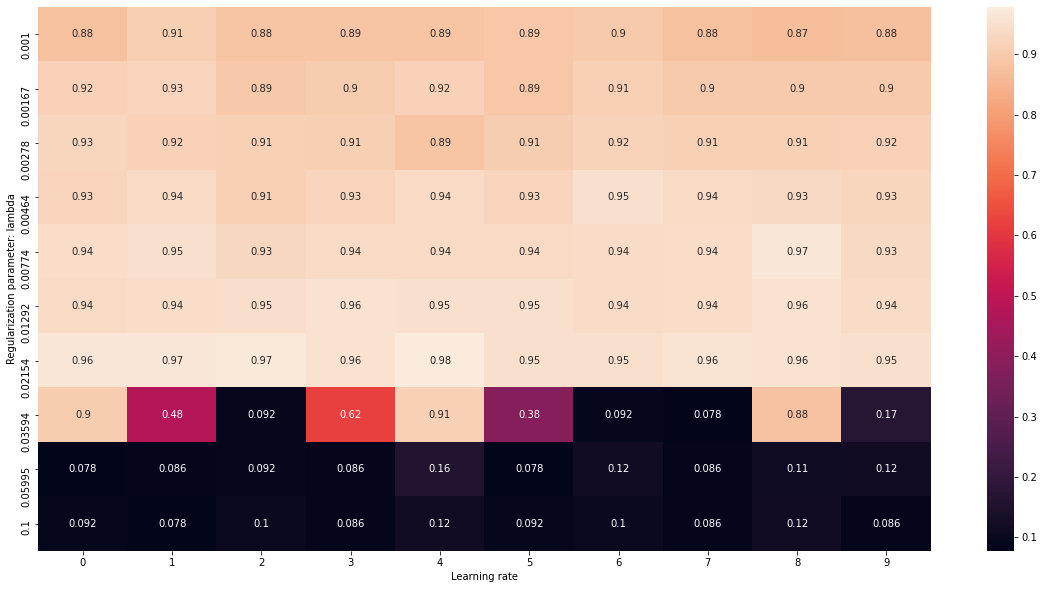

In [21]:

plt.figure(figsize=(20,10))
df = scores_df
sns.heatmap(df,
            annot=True,
            xticklabels=df.columns.values.round(5),
            yticklabels=df.index.values.round(5))
plt.xlabel("Learning rate")
plt.ylabel("Regularization parameter: lambda")
plt.savefig("Tex/Figures/Partd-5.png")

In [22]:
scores_df.max().max()

0.9777777777777777

## Part e): Write your Logistic Regression code, final step.

In [24]:
lmb_vals = np.linspace(1e-3,10,50)
lmb_vals = np.insert(lmb_vals,0,0)
scores = []
import warnings
warnings.filterwarnings('ignore') 

for lmb in tqdm(lmb_vals):
    logreg = LogisticRegression(C=1/lmb,)

    logreg.fit(X_train,y_train)
    scores.append(logreg.score(X_test,y_test))
    
    
scores_df = pd.DataFrame((scores),index=lmb_vals,columns=["Logistic regression"])

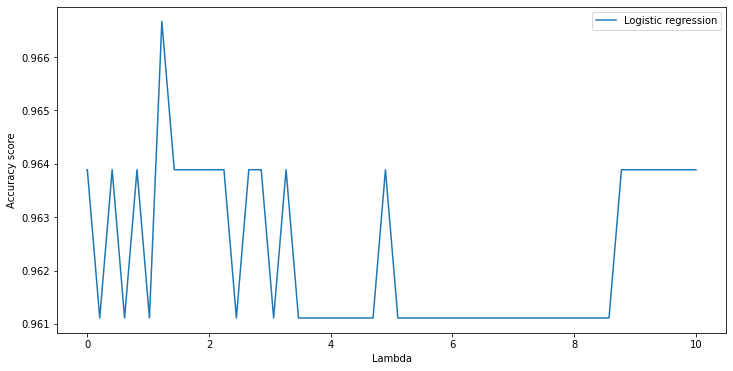

In [25]:

scores_df.plot(figsize=(12,6))
plt.xlabel("Lambda")
plt.ylabel("Accuracy score")
plt.savefig("Tex/Figures/Parte-1.png")